# Урок 9. Домашнее задание. Подбор признаков

### Импортируем библиотеки

In [1]:
# Устанавливаем pandas-profiling для anaconda
#import sys
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install pandas-profiling
#!{sys.executable} -m pip install catboost

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import re

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_union, make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import Normalizer, FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [4]:
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

### Импортируем датасет

In [5]:
train_data = pd.read_csv('train.csv', na_values='NaN', index_col='PassengerId')
test_data  = pd.read_csv('test.csv',  na_values='NaN', index_col='PassengerId')

### Описание признаков

* **PassengerId**: идентификатор записи.
* **Survived**: выжил ли пассажир. Возможные значения: 0 - погиб, 1 - выжил.
* **Pclass**: класс билета. Возможные значение: 1, 2, 3.
* **Name**: имя пассажира.
* **Sex**: пол. Возможные значения: male, female.
* **Age**: возраст пассажира в годах. Рациональное число.
* **SibSp**: количество родственников пассажира на борту: братьев и сестёр (в т.ч. сводных) + жена/муж. Любовники не учитываются.
* **Parch**: количество родственников пассажира на борту: отец, мать; сын, дочь (в т.ч. приёмные). Если ребёнок был с няней, то значение 0.
* **Ticket**: номер билета.
* **Fare**: стоимость билета.
* **Cabin**: номер каюты.
* **Embarked**: порт, в котором пассажир сел на титаник. Возможные значения: C = Cherbourg, Q = Queenstown, S = Southampton.

### План по изучению признаков

1. **Survived** Посмотреть соотношение выживших и погибших. Проверить, что в выборке содержатся только значения 0 и 1.
2. **Pclass** Проверить, что в выборке содержатся только билеты классов 1, 2, 3.
3. **Sex** Проверить, что пол только male и female.
4. **Age** Посмотреть минимальный и максимальный возраст пассажира. Проверить, что нету отрицательных возрастов.
5. **SibSp**, **Parch** Проверить на отсутствие отрицательных значений.
6. **Fare** Посмотреть минимальную и максимальную стоимость. Проверить на отсутствие отрицательных значений.
7. **Ticket**: Проверить на дубликаты.
8. **Cabin** Проверить на отсутствие отрицательных значений. Буквенно-цифровой код.
9. **Embarked** Проверить, что среди значений только C, Q и S.
10. **Name** Посмотреть, какую информацию можно извлечь из имени пассажира.

### Изучаем признаки. EDA

In [6]:
train_data.groupby(['Survived']).size()

Survived
0    549
1    342
dtype: int64

In [7]:
train_data.groupby(['Pclass']).size()

Pclass
1    216
2    184
3    491
dtype: int64

In [8]:
train_data.groupby(['Sex']).size()

Sex
female    314
male      577
dtype: int64

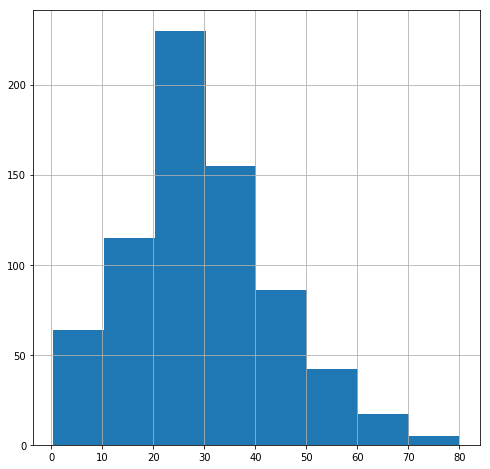

In [9]:
train_data['Age'].hist(bins=8)

Выживаемость в зависимости от возраста:

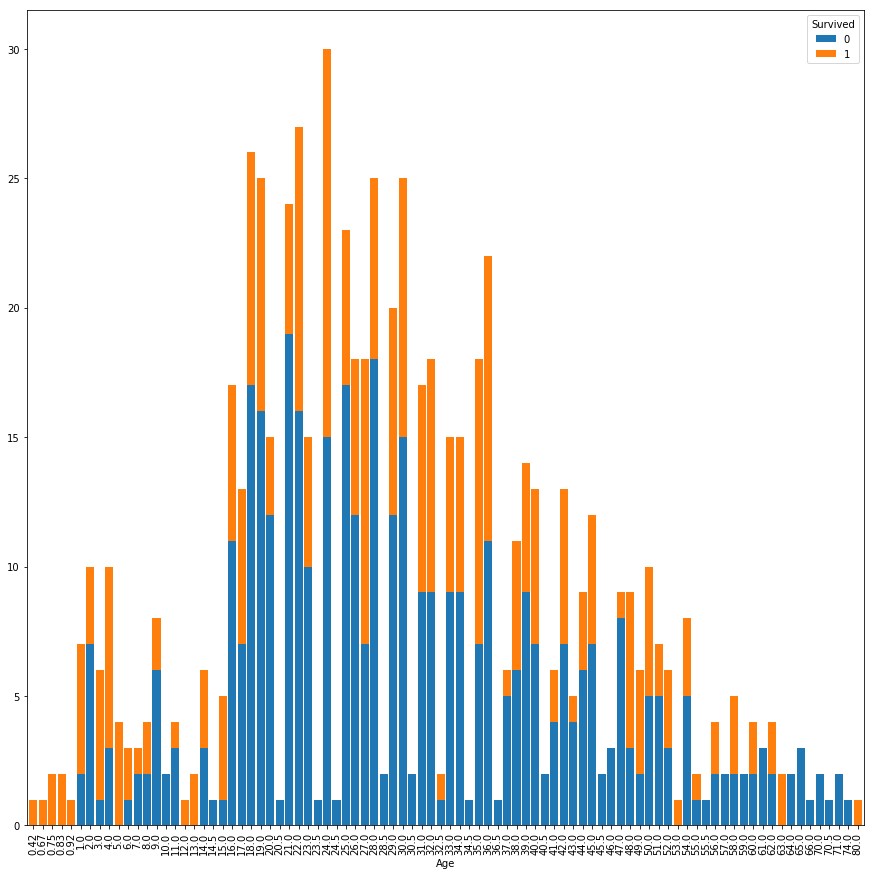

In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
by_age = train_data.groupby(['Age', 'Survived']).size().unstack().plot(kind='bar', stacked=True, width=0.85);

In [11]:
for feature_name in ['Age', 'SibSp', 'Parch', 'Fare']:
    print('Feature name: {}. Min: {}. Max: {} '.format(feature_name, (train_data[[feature_name]].min())[feature_name], (train_data[[feature_name]].max())[feature_name]))

Feature name: Age. Min: 0.42. Max: 80.0 
Feature name: SibSp. Min: 0. Max: 8 
Feature name: Parch. Min: 0. Max: 6 
Feature name: Fare. Min: 0.0. Max: 512.3292 


In [12]:
train_data.groupby(['Embarked']).size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [13]:
duplicated_tickets = pd.DataFrame(train_data.groupby(['Ticket']).size())[train_data.groupby(['Ticket']).size() > 1]
duplicated_tickets.count()

0    134
dtype: int64

Есть билеты, выданные одновременно нескольким пассажирам и билет с нулевой стоимостью. Что это означает?  
Продолжаем анализировать признаки.  
Выведем отчёт как для тренировочных, так и для тестовых данных.

In [14]:
all_data = pd.concat([train_data, test_data])

In [15]:
pandas_profiling.ProfileReport(all_data)

Исследуем имя пассажира.  
Видно, что в имени содержится обращение: "Mr.", "Miss.", "Mrs.".  
Посмотрим на количество уникальных обращений.

In [16]:
titleRegEx = re.compile(',\s*([^\.]+)\.')

titles = all_data['Name'].replace(np.nan, '').apply(lambda row: titleRegEx.search(row)[1])
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [17]:
test_data['Name'].replace(np.nan, '').apply(lambda row: titleRegEx.search(row)[1]).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

Проверяем, что у каждого пассажира указано обращение:

In [18]:
titles.shape[0] == all_data.shape[0]

True

In [19]:
del all_data, by_age

## Шаг 1
Сначала построим простейшую рабочую модель. Для этого воспользуемся частью имеющихся в наличии признаков.

### План по преобразованию признаков
1. Оставляем только numeric признаки:
    * Age
    * Fare
    * Parch
    * SibSp
2. Преобразуем их:
    * Age - не указанные значения заменяем на медианное значение
    * Fare - не указанные и нулевые значения заменяем на медианные

### Преобразование признаков

In [20]:
X = train_data[['Age', 'Fare', 'Parch', 'SibSp']]
X.shape

(891, 4)

In [21]:
y = train_data['Survived']
y.shape

(891,)

In [22]:
vec = make_union(*[
    make_pipeline(FunctionTransformer(lambda X: X[['Age']], validate=False), Imputer(strategy='median'), StandardScaler()),
    make_pipeline(FunctionTransformer(lambda X: X[['Fare']], validate=False), Imputer(strategy='median') , Imputer(strategy='median', missing_values=0), StandardScaler()),
    make_pipeline(FunctionTransformer(lambda X: X[['SibSp', 'Parch']], validate=False), StandardScaler()),
])

In [23]:
X_fitted_transformed = vec.fit_transform(X)
X_fitted_transformed.shape

(891, 4)

### Проверяем с помощью knn
Для подбора оптимального количества соседей используем поиск по сетке с кросс-валидацией

In [24]:
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=[
        {'n_neighbors': range(1, 30)}
    ],
    scoring='accuracy',
    cv=10
)
grid_search_knn.fit(X_fitted_transformed, y)
grid_search_knn.best_params_['n_neighbors']

20

In [25]:
knn = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'])
knn.fit(X_fitted_transformed, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [26]:
scores = cross_val_score(knn, X_fitted_transformed, y, scoring='accuracy', cv=10)
print('Шаг 1. knn. Оценка: %.3f ± %.3f' % (scores.mean(), scores.std()))

Шаг 1. knn. Оценка: 0.721 ± 0.053


In [27]:
# Почему-то отличаются
#scores = cross_val_score(grid_search_knn, X_fitted_transformed, y, scoring='accuracy', cv=10)

### Проверяем с помощью Logistic Regression

In [28]:
lr = LogisticRegressionCV(cv=10)
lr.fit(X_fitted_transformed, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [29]:
accuracy_score(y, lr.predict(X_fitted_transformed))

0.6924803591470258

Освобождаем память

In [30]:
del X, y, vec, X_fitted_transformed, grid_search_knn, scores, lr

## Шаг 2
Улучшим модель. Для этого добавляем категориальные признаки и конструируем собственные

### План по преобразованию признаков
1. Оставляем numeric признаки:
    * Age
    * Fare
    * Parch
    * SibSp
2. Оставляем категориальные признаки:
    * Sex
    * Embarked
    * Pclass
3. Добавляем признаки:
    * Relatives - общее количество родственников (SibSp + Parch)
    * Title - обращение, указанное в имени.
    * IsChild - ребёнок до 16-ти
    * IsElder - пожилой человек, после 50-ти
4. Преобразования:
    * Age - не указанные значения заменяем на медианное значение
    * Fare - не указанные и нулевые значения заменяем на медианные
    * Emabarked - не указанные значения заменяем на наиболее часто встречающиеся

### Преобразование признаков
Создадим вспомогательные классы для преобразования признаков

In [31]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [32]:
def prepare_data_set(data_set):
    X = data_set[['Age', 'Fare', 'Parch', 'SibSp', 'Sex', 'Embarked', 'Pclass', 'Name']]
    
    most_frequent_embarked = X['Embarked'].value_counts().index[0]
    X['Embarked'] = X['Embarked'].fillna(value=most_frequent_embarked)
    
    X['Relatives'] = X['Parch'] + X['SibSp']
    
    X['IsChild'] = X.apply(lambda row: 1 if row['Age'] <= 16 else 0, axis=1)
    X['IsElder'] = X.apply(lambda row: 1 if row['Age'] >= 50 else 0, axis=1)
    
    X['Title'] = X['Name'].replace(np.nan, '').apply(lambda row: titleRegEx.search(row)[1])
    X.drop('Name', axis=1, inplace=True)
    
    X['Title'] = X['Title'].replace(['Mr', 'Don', 'Sir'], 'Mr')
    X['Title'] = X['Title'].replace(['Mme', 'Lady', 'Dona', 'Mrs'], 'Mrs')
    X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
    X['Title'] = X['Title'].replace(['Master', 'Major', 'Col', 'Capt'], 'Army')
    X['Title'] = X['Title'].replace(['the Countess', 'Jonkheer', 'Rev', 'Dr'], 'Other')
   
    return X

In [33]:
def fit_transform_data_set(X):
    vec = make_union(*[
        make_pipeline(FunctionTransformer(lambda X: X[['Age']], validate=False), Imputer(strategy='median'), StandardScaler()),
        make_pipeline(FunctionTransformer(lambda X: X[['Fare']], validate=False), Imputer(strategy='median') , Imputer(strategy='median', missing_values=0), StandardScaler()),
        make_pipeline(FunctionTransformer(lambda X: X[['SibSp', 'Parch']], validate=False), StandardScaler()),
        make_pipeline(FunctionTransformer(lambda X: X[['Sex']], validate=False), LabelEncoderPipelineFriendly()),
        make_pipeline(FunctionTransformer(lambda X: X[['Embarked']], validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
        make_pipeline(FunctionTransformer(lambda X: X[['Pclass']], validate=False),  OneHotEncoder(sparse=False)),
        make_pipeline(FunctionTransformer(lambda X: X[['Relatives']], validate=False), StandardScaler()),
        make_pipeline(FunctionTransformer(lambda X: X[['IsChild']], validate=False)),
        make_pipeline(FunctionTransformer(lambda X: X[['Title']], validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    ])
    
    return vec.fit_transform(X)
    

In [34]:
X = prepare_data_set(train_data)
y = train_data['Survived']
X_fitted_transformed = fit_transform_data_set(X)

N:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
N:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
N:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
N:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

### Проверяем с помощью knn
Для подбора оптимального количества соседей используем поиск по сетке с кросс-валидацией

In [35]:
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=[
        {'n_neighbors': range(1, 30)}
    ],
    scoring='accuracy',
    cv=10
)
grid_search_knn.fit(X_fitted_transformed, y)
grid_search_knn.best_params_['n_neighbors']

24

In [36]:
knn = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'])
knn.fit(X_fitted_transformed, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=24, p=2,
           weights='uniform')

In [37]:
scores = cross_val_score(knn, X_fitted_transformed, y, scoring='accuracy', cv=10)
print('Шаг 1. knn. Оценка: %.3f ± %.3f' % (scores.mean(), scores.std()))

Шаг 1. knn. Оценка: 0.821 ± 0.034


### Проверяем с помощью Logistic Regression

In [38]:
lr = LogisticRegressionCV(cv=10)
lr.fit(X_fitted_transformed, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [39]:
accuracy_score(y, lr.predict(X_fitted_transformed))

0.8271604938271605

И для knn, и для lr на кросс-валидации данные лучше, чем в шаге 1.

# Prepare test data

In [40]:
%%capture
del X
X = prepare_data_set(test_data)
X_fitted_transformed = fit_transform_data_set(X)

In [41]:
df_predicted = pd.DataFrame({'PassengerId':X.index.values, 'Survived': lr.predict(X_fitted_transformed)})

In [42]:
df_predicted.to_csv('titanic_step_2_final.csv', sep=',', index=False)

Andrey Mitrofanov
https://www.kaggle.com/andrewmitrofanov